In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from netCDF4 import Dataset

import seaborn as sns



import matplotlib.pyplot as plt

path = os.getcwd()

import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

import xgboost as xgb
import pickle

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10548794626854465387
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3645898752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15799989963232699116
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


### 데이터셋 구축

In [2]:
# In[] SMOKE-CMAQ
# CMAQ 연평균 PM농도
pm2_5 = np.array([])

for i in range(1,120):
    a = 'ACONC.' + str(i)
    nc = Dataset(a, 'r')
    pm2_5 = np.append(pm2_5, np.array([[[nc.variables['PM2_5']]]]))
    
pm2_5 = np.reshape(pm2_5, [119,82,67])
pm2_5 = pm2_5[:,8:-10,2:-1]
pm2_5 = np.reshape(pm2_5, [119,64,64]) # convolution 연산을 위해

pm = pm2_5


y1 = np.array([])
y2 = np.array([])
y3 = np.array([])
y4 = np.array([])
y5 = np.array([])
y6 = np.array([])

for i in range(1,120):
    a = 'EMIS_AVG.' + str(i)
    nc = Dataset(a, 'r')
    y1 = np.append(y1, np.array([[[nc.variables['SO2']]]]))
    y2 = np.append(y2, np.array([[[nc.variables['PM2_5']]]]))
    y3 = np.append(y3, np.array([[[nc.variables['NOx']]]]))
    y4 = np.append(y4, np.array([[[nc.variables['VOCs']]]]))
    y5 = np.append(y5, np.array([[[nc.variables['NH3']]]]))
    y6 = np.append(y6, np.array([[[nc.variables['CO']]]]))
    
y1 = np.reshape(y1, [119,82,67])
y1 = y1[:,8:-10,2:-1]
y1 = np.reshape(y1, [119,64,64])
y1_max = np.max(y1)
y1_min = np.min(y1)

y2 = np.reshape(y2, [119,82,67])
y2 = y2[:,8:-10,2:-1]
y2 = np.reshape(y2, [119,64,64])
y2_max = np.max(y2)
y2_min = np.min(y2)

y3 = np.reshape(y3, [119,82,67])
y3 = y3[:,8:-10,2:-1]
y3 = np.reshape(y3, [119,64,64])
y3_max = np.max(y3)
y3_min = np.min(y3)

y4 = np.reshape(y4, [119,82,67])
y4 = y4[:,8:-10,2:-1]
y4 = np.reshape(y4, [119,64,64])
y4_max = np.max(y4)
y4_min = np.min(y4)

y5 = np.reshape(y5, [119,82,67])
y5 = y5[:,8:-10,2:-1]
y5 = np.reshape(y5, [119,64,64])
y5_max = np.max(y5)
y5_min = np.min(y5)
    
y6 = np.reshape(y6, [119,82,67])
y6 = y6[:,8:-10,2:-1]
y6 = np.reshape(y6, [119,64,64])


def pm_data():
    a = np.concatenate((y3,y1,y4,y5), axis=0) # PM2.5, SO2, NH3
    a = np.reshape(a,[4,119,64,64]) # data generation for CNN ??
    a = np.transpose(a, (1,2,3,0)) # CNN 학습을 위한 순서변경
    print(np.shape(a))
    
    y = pm
    
    y = np.reshape(y, [119,64,64,1]) # CNN output data
    x_train = a[0:70]
    y_train = y[0:70]
    x_test = a[70:]
    pm2_5 = y[70:]
    return x_train, y_train, x_test, pm2_5, a, y


pm_data1 = pm_data()
x_train, y_train, x_test, pm2_5, a, y = pm_data1[0], pm_data1[1], pm_data1[2], pm_data1[3], pm_data1[4], pm_data1[5]#, pm_data1[6], pm_data1[7] 


(119, 64, 64, 4)


In [3]:
x_train.shape

(70, 64, 64, 4)

* smoke -> cmaq 네트워크 구축

In [4]:
OUTPUT_CHANNELS = 1

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Unet():
  # data_augmentation = tf.keras.Sequential([
  #   # tf.keras.layers.RandomFlip('horizontal'), # "horizontal", "vertical", or "horizontal_and_vertical"
  #   # tf.keras.layers.RandomRotation(0.2),
  #   tf.keras.layers.GaussianNoise(   # 노이즈레이어 이부분도 학습에서만 활성화됨
  #       1, seed=None,
  #   )
  #   ])




  inputs = tf.keras.layers.Input(shape=[64, 64, 4])

  down_stack = [
    downsample(64, 3),  # (batch_size, 64, 64, 64)
    downsample(128, 3),  # (batch_size, 32, 32, 128)
    downsample(256, 3),  # (batch_size, 16, 16, 256)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3),  # (batch_size, 8, 8, 1024)
    upsample(256, 3),  # (batch_size, 16, 16, 512)
    upsample(128, 3),  # (batch_size, 32, 32, 256)
    upsample(64, 3),  # (batch_size, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 2,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         )  # (batch_size, 256, 256, 3)  activation='tanh'

  x = inputs
  # x = data_augmentation(x)      

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [5]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)
x_test_tensor = tf.convert_to_tensor(x_test,dtype = float)
y_train_resize_tensor = tf.convert_to_tensor(y_train,dtype = float)
y_test_resize_tensor = tf.convert_to_tensor(pm2_5,dtype = float)

batch_size = 20
epoch = 2000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {epoch}')

train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor), tf.data.Dataset.from_tensor_slices(y_train_resize_tensor),))
shuffled_dataset = train_dataset.shuffle(buffer_size=buffer_len)

net_1 = Unet()
# test_net = Unet()
# pred = test_net(x_train)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 2000


In [7]:
loss = tf.keras.losses.MeanSquaredError()
l_rate = 0.0001
min_l_rate = 0.0000005
optimizer = tf.keras.optimizers.Adam(l_rate)
@tf.function()
def train_step(input, label, network, loss_fun):
  
  with tf.GradientTape() as tape:
    ##로스 계산
    pred = network(input)
    
    loss = loss_fun(label, pred)
  grads = tape.gradient(loss, network.trainable_variables)
  optimizer.apply_gradients(zip(grads, network.trainable_variables))
  return loss


for epoc in range(epoch):
    count = 0

    if epoc%1000 == 0 and l_rate >= min_l_rate and epoc != 0:
      l_rate /= 5
      @tf.function()
      def train_step(input, label, network, loss_fun):
        
        with tf.GradientTape() as tape:
          ##로스 계산
          pred = network(input)
          
          loss = loss_fun(label, pred)
        grads = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(grads, network.trainable_variables))
        return loss

    for batch in shuffled_dataset.batch(batch_size).take(n_run):

        count += 1
        mse_loss = train_step(batch[0],batch[1], net_1,loss).numpy()
        print(f"batch: {count}/{n_run} ---epoch: {epoc}/{epoch}--- mse-loss: {mse_loss}")

batch: 1/4.0 ---epoch: 0/2000--- mse-loss: 178.0139617919922
batch: 2/4.0 ---epoch: 0/2000--- mse-loss: 178.8428497314453
batch: 3/4.0 ---epoch: 0/2000--- mse-loss: 176.95701599121094
batch: 4/4.0 ---epoch: 0/2000--- mse-loss: 177.22415161132812
batch: 1/4.0 ---epoch: 1/2000--- mse-loss: 177.624267578125
batch: 2/4.0 ---epoch: 1/2000--- mse-loss: 177.615966796875
batch: 3/4.0 ---epoch: 1/2000--- mse-loss: 177.75657653808594
batch: 4/4.0 ---epoch: 1/2000--- mse-loss: 178.27279663085938
batch: 1/4.0 ---epoch: 2/2000--- mse-loss: 177.9839630126953
batch: 2/4.0 ---epoch: 2/2000--- mse-loss: 177.0894012451172
batch: 3/4.0 ---epoch: 2/2000--- mse-loss: 177.6326446533203
batch: 4/4.0 ---epoch: 2/2000--- mse-loss: 177.69232177734375
batch: 1/4.0 ---epoch: 3/2000--- mse-loss: 177.91659545898438
batch: 2/4.0 ---epoch: 3/2000--- mse-loss: 177.0197296142578
batch: 3/4.0 ---epoch: 3/2000--- mse-loss: 176.77554321289062
batch: 4/4.0 ---epoch: 3/2000--- mse-loss: 175.6420135498047
batch: 1/4.0 ---epo

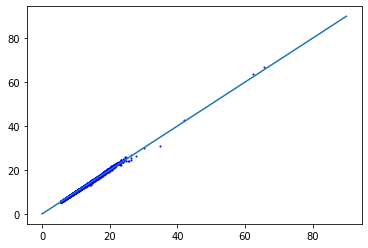

In [8]:
pre = net_1(x_test_tensor)
plt.plot(pre.numpy()[2][::-1].reshape(-1), y_test_resize_tensor.numpy()[2][::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])


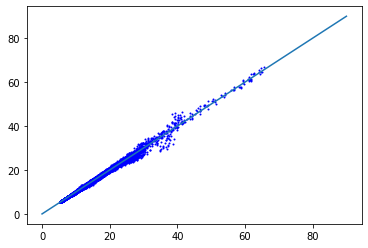

In [9]:
plt.plot(pre.numpy()[::-1].reshape(-1), y_test_resize_tensor.numpy()[::-1].reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

<AxesSubplot: >

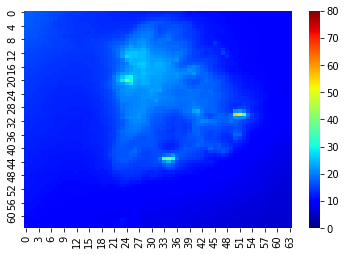

In [12]:
sns.heatmap(pre.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

<AxesSubplot: >

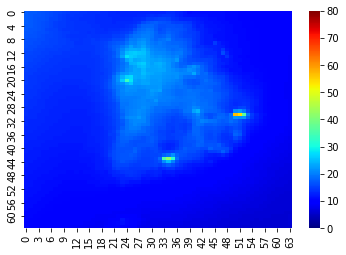

In [13]:
sns.heatmap(y_test_resize_tensor.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

* z-vector

In [27]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((16, 16, 256)))
    assert model.output_shape == (None, 16, 16, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # model.add(tf.keras.layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    model.add(tf.keras.layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # 실제 값 스케일로 예측하기 위해 활성화함수x
    assert model.output_shape == (None, 64, 64, 4)

    return model

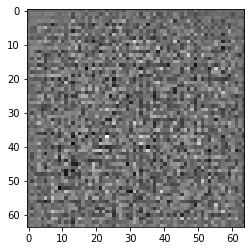

In [28]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [29]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 4]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [30]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00021846]], shape=(1, 1), dtype=float32)


In [31]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [32]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
import time
from IPython import display
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



import matplotlib
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  plt.savefig(os.path.join(path,'plots','gen_plots','NOx_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(20,20))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 1][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  plt.savefig(os.path.join(path,'plots','gen_plots','SO2_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(20,20))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 2][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  plt.savefig(os.path.join(path,'plots','gen_plots','VOCs_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

  fig = plt.figure(figsize=(20,20))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 3][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
      plt.axis('off')

  plt.savefig(os.path.join(path,'plots','gen_plots','NH3_image_at_epoch_{:04d}.png'.format(epoch)))
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다., 15에폭당 한번씩 실행
    if (epoch + 1) % 15 == 0:
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                              epoch + 1,
                              seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [35]:
x_train_tensor = tf.convert_to_tensor(x_train,dtype = float)

batch_size = 20
BATCH_SIZE = batch_size
EPOCHS = 2000
buffer_len = len(x_train_tensor)
n_run = np.ceil(len(x_train_tensor)/batch_size)
print(f'배치사이즈: {batch_size}, 에폭당 학습수: {n_run}, 에폭: {EPOCHS}')

train_dataset_smoke = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train_tensor)))
shuffled_train_dataset_smoke = train_dataset_smoke.batch(BATCH_SIZE).shuffle(buffer_size=buffer_len)

배치사이즈: 20, 에폭당 학습수: 4.0, 에폭: 2000


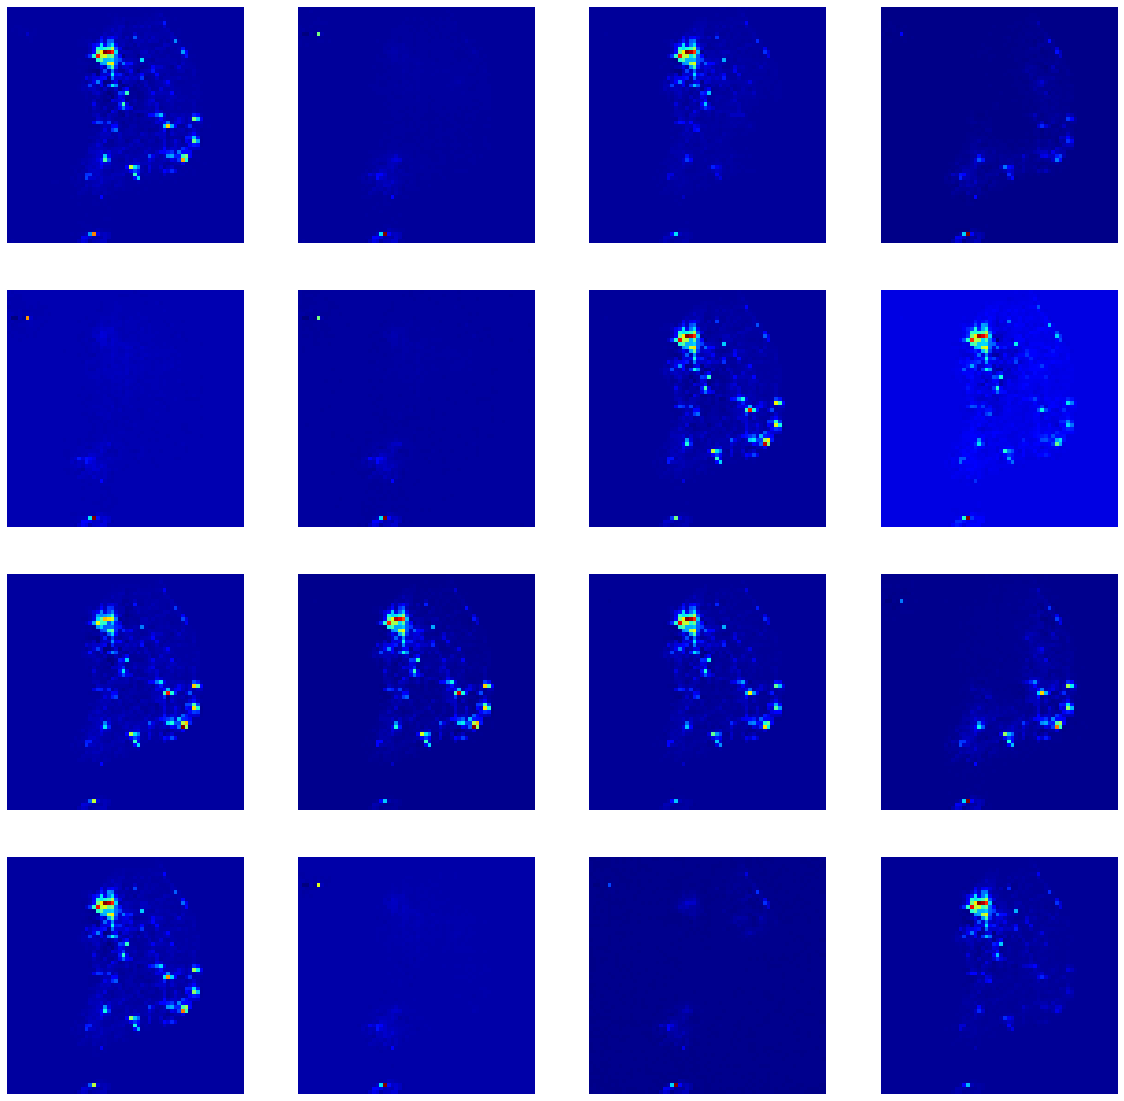

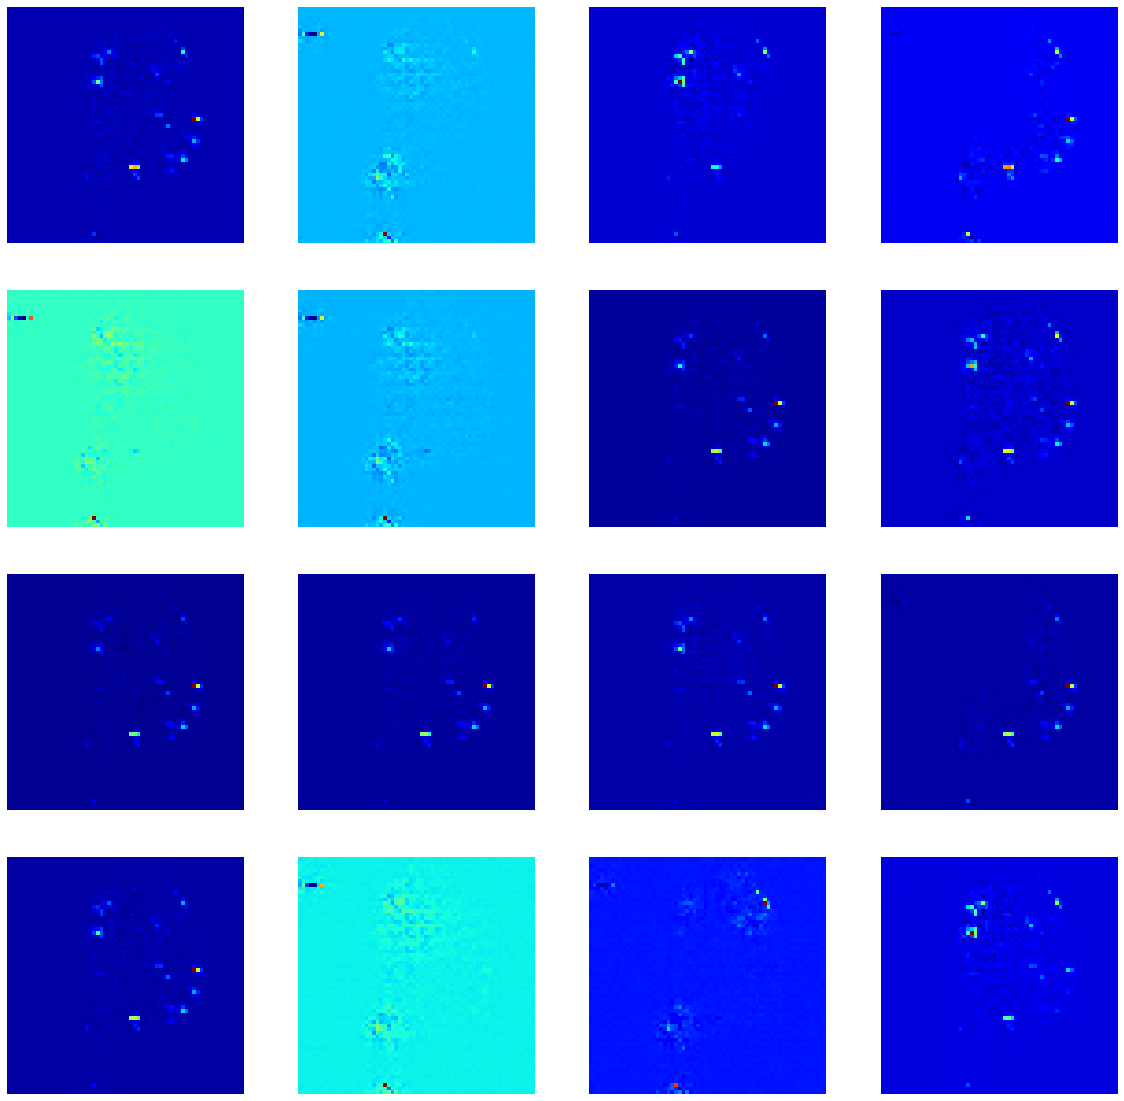

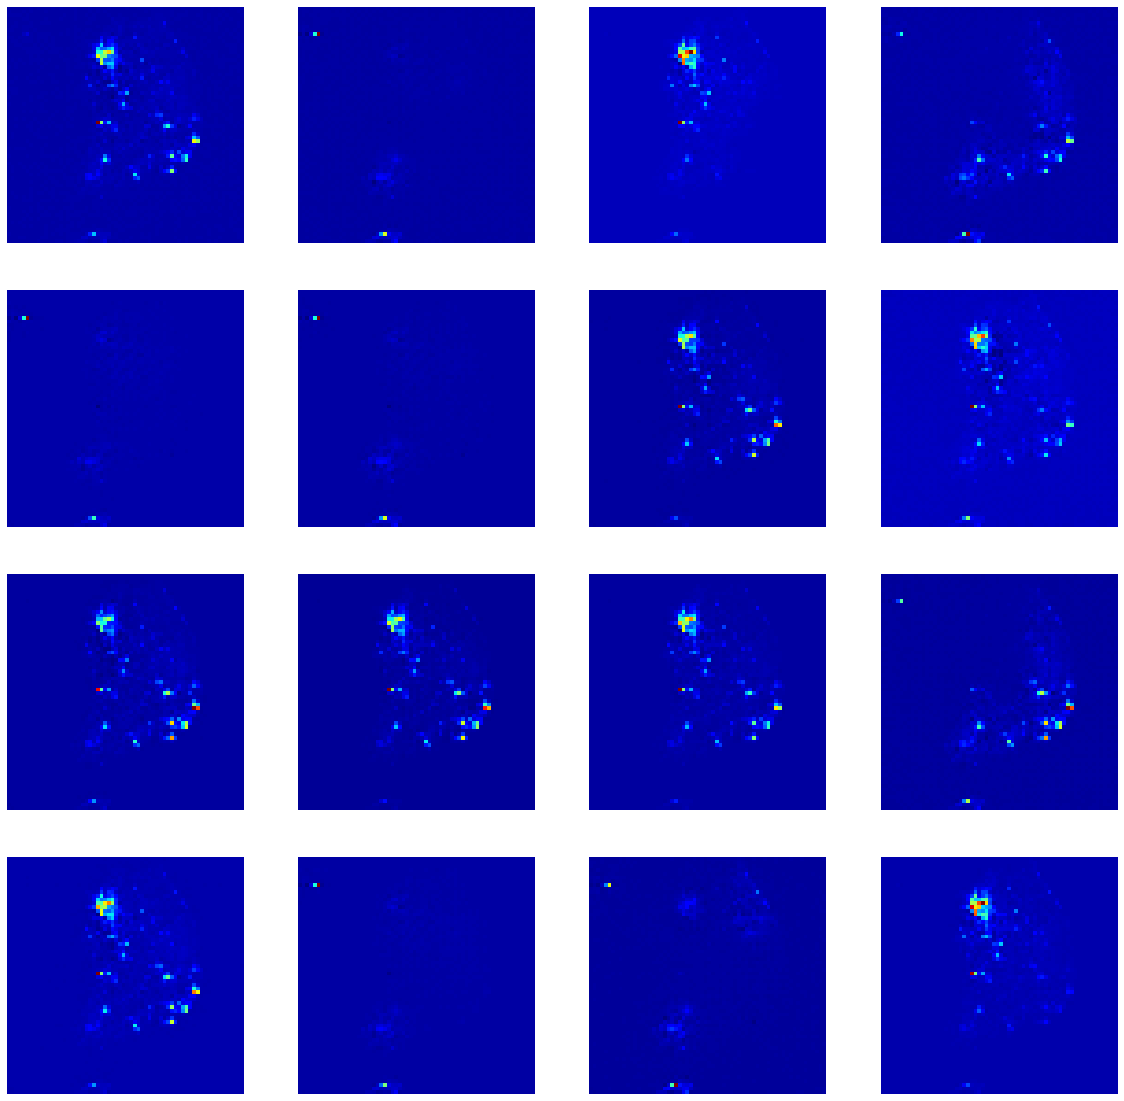

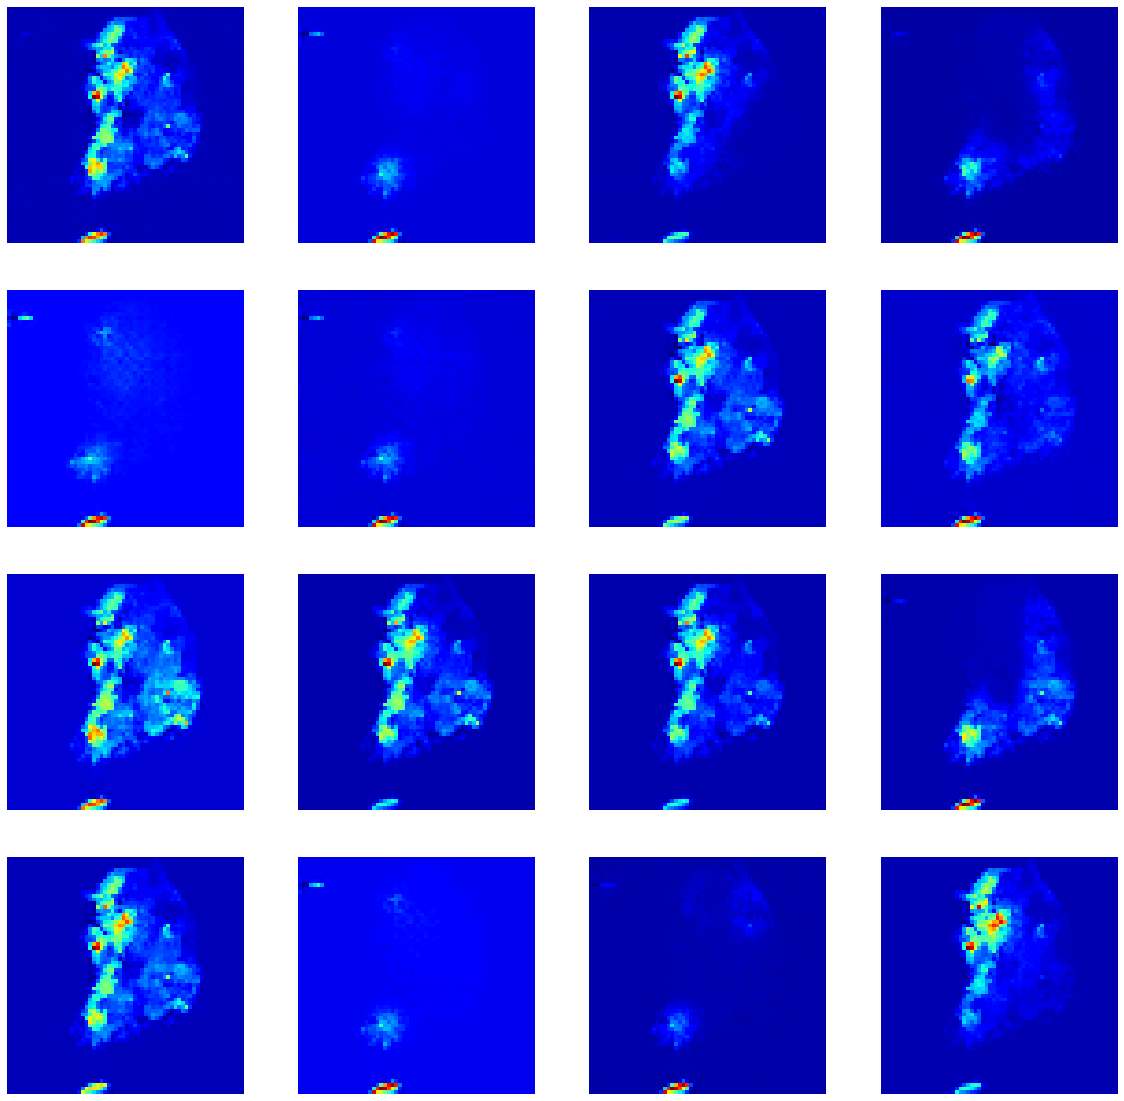

CPU times: total: 6min 20s
Wall time: 9min 29s


In [36]:
%%time
train(shuffled_train_dataset_smoke, EPOCHS)

In [47]:
re = generator(seed)

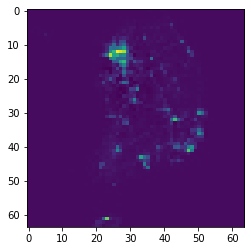

In [48]:
plt.imshow(re[0][:,:,0][::-1])

In [49]:
np.min(re[0][:,:,0])

-0.17686367

In [50]:

np.max(x_train_tensor[0][:,:,0])

11.844604

* gen smoke to surrogate model

In [51]:
gen_input = generator(seed)

In [52]:
pre_gen = net_1(gen_input)

<AxesSubplot: >

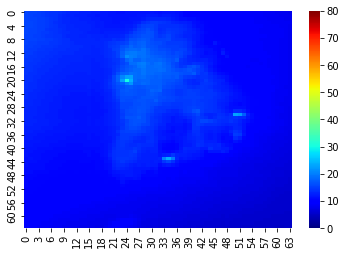

In [53]:
sns.heatmap(pre_gen.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

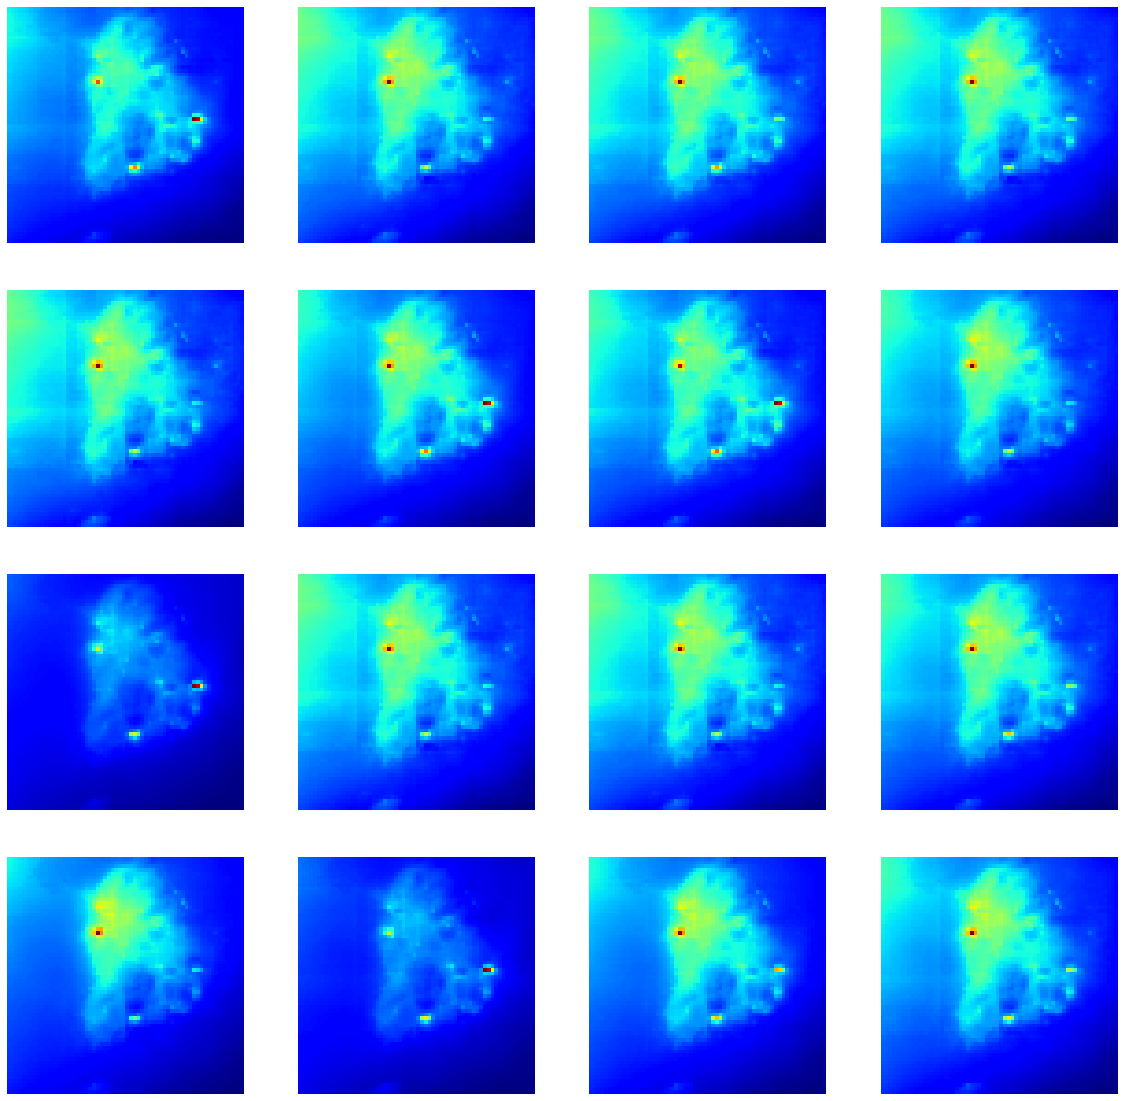

In [54]:
gen_input = generator(tf.random.normal([num_examples_to_generate, noise_dim]))
pre_gen = net_1(gen_input)

fig = plt.figure(figsize=(20,20))

for i in range(pre_gen.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(pre_gen[i, :, :, 0][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
    plt.axis('off')

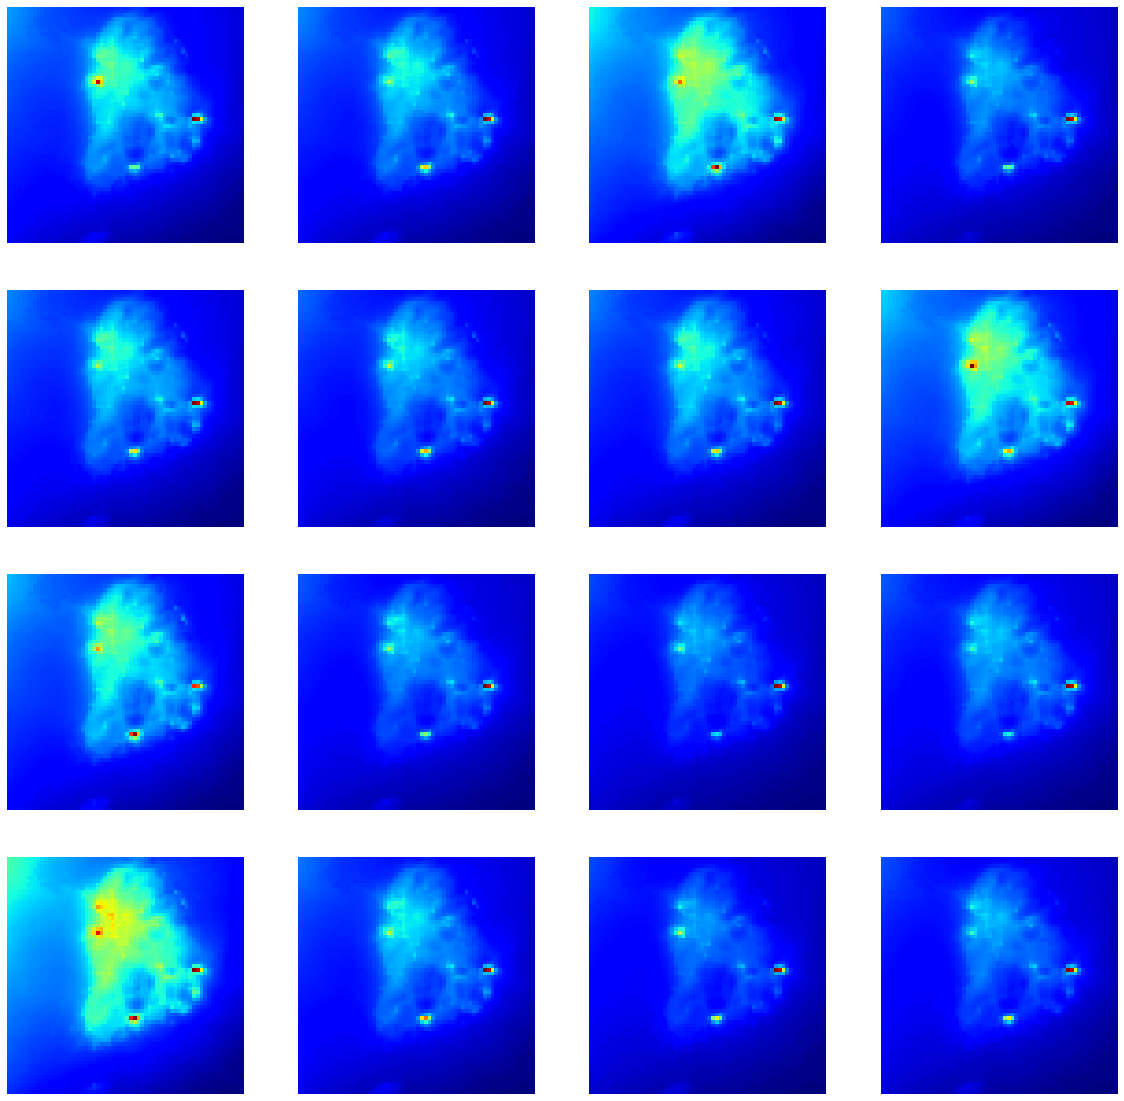

In [55]:
fig = plt.figure(figsize=(20,20))

for i in range(y_test_resize_tensor[16:32].shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(y_test_resize_tensor[16:32][i, :, :, 0][::-1], cmap = 'jet',norm = matplotlib.colors.Normalize())
    plt.axis('off')

<AxesSubplot: >

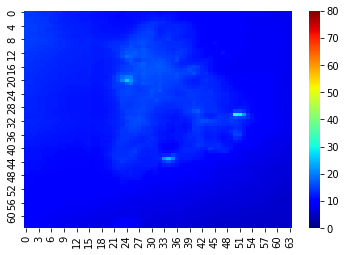

In [56]:
sns.heatmap(pre_gen.numpy()[0,:,:,0][::-1], cmap = 'jet',vmin=0, vmax=80)

* generate된 smoke셋에 왼쪽상단에 점오염원같은것이 찍혀서 확인한 결과
* 실제로 있음
* 저농도라서 전체맵으로 보면 잘 안보임
* generate된 데이터에서는 육지에대해서 배출량이 아주 적은경우? 아니면 음수처리를 안해주어서 잘 보이는듯함

--> 확인결과 백령도인듯함

In [57]:
# 추후 업데이트할때 음수 출력안되도록 수정하기
np.min(gen_input), np.max(gen_input),

(-0.36856228, 14.199307)

0.0 0.01332138


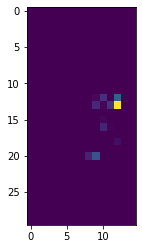

In [58]:
plt.imshow(x_train_tensor[2,:30,:15,0][::-1],)
print(np.min(x_train_tensor[2,:30,:15,0][::-1]), np.max(x_train_tensor[2,:30,:15,0][::-1]))

0.0 0.058395386


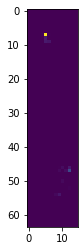

In [59]:
plt.imshow(x_train_tensor[2,:,:15,0][::-1])
print(np.min(x_train_tensor[2,:,:15,0][::-1]), np.max(x_train_tensor[2,:,:15,0][::-1]))

0.0 4.3708262


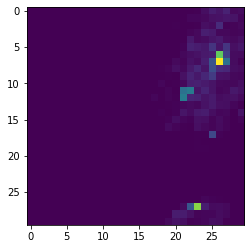

In [60]:
plt.imshow(x_train_tensor[2,:30,:30,0][::-1])
print(np.min(x_train_tensor[2,:30,:30,0][::-1]), np.max(x_train_tensor[2,:30,:30,0][::-1]))

0.0 14.317917


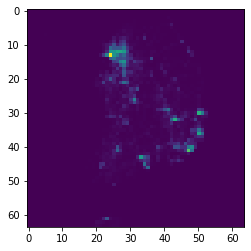

In [61]:
plt.imshow(x_train_tensor[2,:,:,0][::-1])
print(np.min(x_train_tensor[2,:,:,0][::-1]), np.max(x_train_tensor[2,:,:,0][::-1]))